In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import math as mt
import time
import json

Preview of data.

In [9]:
def get_list_of_dicts(fname): 
    return [json.loads(i) for i in open(fname, "rt")]

raw_data = get_list_of_dicts("Amazon_Instant_Video_5.json")

ratings_df = pd.DataFrame(raw_data).loc[:, ["reviewerID", "asin", "overall"]]
ratings_df.head()

,reviewerID,asin,overall
0,A11N155CW1UV02,B000H00VBQ,2.0
1,A3BC8O2KCL29V2,B000H00VBQ,5.0
2,A60D5HQFOTSOM,B000H00VBQ,1.0
3,A1RJPIGRSNX4PW,B000H00VBQ,4.0
4,A16XRPF40679KG,B000H00VBQ,5.0


In [11]:
print('There are in total', len(ratings_df), 'ratings.')

n_users = ratings_df['reviewerID'].unique().shape[0]
n_items = ratings_df['asin'].unique().shape[0]
print ('There are', n_users,  'distinct users and', n_items, 'distinct movies.')

There are in total 37126 ratings.
There are 5130 distinct users and 1685 distinct movies.


In [12]:
users = ratings_df['reviewerID'].unique()
sparsity=round(1.0-len(ratings_df)/float(n_users*n_items),3)
print('The sparsity level of datasets is', sparsity*100, '%')

The sparsity level of datasets is 99.6 %


Train-test splitting.

In [13]:
train_data, test_data = train_test_split(ratings_df, test_size=0.2)

Item similarity model

In [17]:
class item_similarity_recommender():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.movies_dict = None
        self.rev_movies_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique movies corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())       
        return user_items
        
    #Get unique users for a given movie
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())            
        return item_users
        
    #Get unique movies in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_movies, all_movies):
        #Get users for all movies in user_movies.
        user_movies_users = []        
        for i in range(0, len(user_movies)):
            user_movies_users.append(self.get_item_users(user_movies[i]))
            
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_movies), len(all_movies))), float)           
        #Calculate similarity between user movies and all unique moviesin the training data
        for i in range(0,len(all_movies)):
            #Calculate unique users of movie i
            movies_i_data = self.train_data[self.train_data[self.item_id] == all_movies[i]]
            users_i = set(movies_i_data[self.user_id].unique())
            
            for j in range(0,len(user_movies)):                           
                #Get the intersection of users of moviess i and j
                users_j = user_movies_users[j]
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of users of movies i and j
                    users_union = users_i.union(users_j)                   
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0        
        return cooccurence_matrix

    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_movies, user_movies):
        #Calculate a weighted average of the scores in cooccurence matrix for all user_movies.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value, maintaining the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Top 10 item based recommendations
        columns = ['user_id', 'movie', 'score', 'rank']
        df = pd.DataFrame(columns=columns)
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_movies[sort_index[i][1]] not in user_movies and rank <= 10:
                df.loc[len(df)]=[user,all_movies[sort_index[i][1]],sort_index[i][0],rank]
                rank += 1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no movie for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to make recommendations
    def recommend(self, user):
        user_movies = self.get_user_items(user)    
        all_movies = self.get_all_items_train_data()
        cooccurence_matrix = self.construct_cooccurence_matrix(user_movies, all_movies)
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_movies, user_movies)
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):        
        user_movies = item_list
        all_movies = self.get_all_items_train_data()
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_movies)
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_movies, user_movies)
        return df_recommendations

In [19]:
#Create the model
is_model =item_similarity_recommender()
is_model.create(train_data, 'reviewerID', 'asin')

#Make recommendations
user_id = users[2]
recom1 = is_model.recommend(user_id)
print('For user', user_id, 'the recommended asins are:')
print(list(recom1['movie']))

For user A60D5HQFOTSOM the recommended asins are:
['B007UMK3SA', 'B007PYFAP4', 'B00A2KIMH6', 'B00C6C96UK', 'B0040HNZTW', 'B005D63I78', 'B0045TGRSG', 'B009O6QKKK', 'B000LVIIUC', 'B0062246R8']


SVD recommender model

In [22]:
from scipy.sparse.linalg import svds

class svd_recommender():
    def __init__(self):
        self.train_data = None
        self.k = None
    
    #Create the svd recommender model
    def create(self, train_data, k):
        self.train_data = train_data
        self.k = k
        
    #Get unique items (movie) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data['reviewerID'] == user]
        user_items = list(user_data['asin'].unique())        
        return user_items

    #Make recommendations using SVD 
    def recommend(self, user): 
        user_movies = self.get_user_items(user) 
        #get SVD components from train matrix. Choose k.
        train_data_matrix = self.train_data.pivot_table(index=['reviewerID'],columns=['asin'],values='overall',fill_value=0)
        train_data_matrix = train_data_matrix.astype(float)
        u, s, vt = svds(train_data_matrix, self.k)
        s_diag_matrix=np.diag(s)
        X_pred = -np.dot(np.dot(u, s_diag_matrix), vt)
        idx = train_data_matrix.index.get_loc(user)
        recom = []
        rank = 1
        for i in (X_pred[idx, :]).argsort():
            movie = list(train_data_matrix)[i]
            if movie not in user_movies and rank <= 10:
                recom.append(movie)
                rank += 1
        return recom

In [23]:
#Create the model
svd_model = svd_recommender()
svd_model.create(train_data, 2)

#Make recommendations
recom = svd_model.recommend(user_id)
print('For user', user_id, 'the recommended asins are:')
print(list(recom))

For user A60D5HQFOTSOM the recommended asins are:
['B00APE00H4', 'B006Z48TZS', 'B004MWZLYC', 'B00DAHSVYC', 'B009FZFONO', 'B005544TRQ', 'B008BQ8VOC', 'B00DQISQX6', 'B00H7NDSPC', 'B00F87ZUYG']


Model Evaluation (Precision-recall)

In [29]:
import random

class precision_recall_calculator():    
    def __init__(self, test_data, train_data, svd, is_model):
        self.test_data = test_data
        self.train_data = train_data
        self.user_test_sample = None
        self.model1 = svd
        self.model2 = is_model
        
        self.ism_training_dict = dict()
        self.svd_training_dict = dict()
        self.test_dict = dict()
    
    #Method to return random percentage of values from a list
    def remove_percentage(self, list_a, percentage):
        k = int(len(list_a) * percentage)
        random.seed(0)
        indicies = random.sample(range(len(list_a)), k)
        new_list = [list_a[i] for i in indicies]    
        return new_list
    
    #Create a test sample of users for use in calculating precision and recall
    def create_user_test_sample(self, percentage):
        #Find users common between training and test set
        users_test_and_training = list(set(self.test_data['reviewerID'].unique()).intersection(set(self.train_data['reviewerID'].unique())))
        print("Length of user_test_and_training:", len(users_test_and_training))
        #Take only random user_sample of users for evaluations
        self.users_test_sample = self.remove_percentage(users_test_and_training, percentage)
        print("Length of user sample:", len(self.users_test_sample))
        
    #Method to generate top 10 recommendations for test_sample users
    def get_test_sample_recommendations(self):
        for user_id in self.users_test_sample:
            #Get items for user_id from item similarity model
            print("Getting recommendations for user:", user_id)
            user_sim_items = self.model2.recommend(user_id)
            self.ism_training_dict[user_id] = list(user_sim_items['movie'])
    
            #Get items for user_id from svd model
            user_svd = self.model1.recommend(user_id)
            self.svd_training_dict[user_id] = list(user_svd)
    
            #Get items for user_id from test_data
            test_data_user = self.test_data[self.test_data['reviewerID'] == user_id]
            self.test_dict[user_id] = set(test_data_user['asin'].unique() )
    
    #Method to calculate the precision and recall measures
    def calculate_precision_recall(self):
        #Create cutoff list for precision and recall calculation
        cutoff_list = list(range(1,11))
        #For each distinct cutoff:
        #    1. For each distinct user, calculate precision and recall.
        #    2. Calculate average precision and recall.
        ism_avg_precision_list = []
        ism_avg_recall_list = []
        svd_avg_precision_list = []
        svd_avg_recall_list = []

        num_users_sample = len(self.users_test_sample)
        for N in cutoff_list:
            ism_sum_precision = 0
            ism_sum_recall = 0
            svd_sum_precision = 0
            svd_sum_recall = 0
            ism_avg_precision = 0
            ism_avg_recall = 0
            svd_avg_precision = 0
            svd_avg_recall = 0

            for user_id in self.users_test_sample:
                ism_hitset = self.test_dict[user_id].intersection(set(self.ism_training_dict[user_id][0:N]))
                svd_hitset = self.test_dict[user_id].intersection(set(self.svd_training_dict[user_id][0:N]))
                testset = self.test_dict[user_id]
        
                svd_sum_precision += float(len(svd_hitset))/float(N)
                svd_sum_recall += float(len(svd_hitset))/float(len(testset))

                ism_sum_precision += float(len(ism_hitset))/float(len(testset))
                ism_sum_recall += float(len(ism_hitset))/float(N)
        
            svd_avg_precision = svd_sum_precision/float(num_users_sample)
            svd_avg_recall = svd_sum_recall/float(num_users_sample)
    
            ism_avg_precision = ism_sum_precision/float(num_users_sample)
            ism_avg_recall = ism_sum_recall/float(num_users_sample)

            ism_avg_precision_list.append(ism_avg_precision)
            ism_avg_recall_list.append(ism_avg_recall)
    
            svd_avg_precision_list.append(svd_avg_precision)
            svd_avg_recall_list.append(svd_avg_recall)
            
        return (svd_avg_precision_list, svd_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list)
     
    #A wrapper method to calculate all the evaluation measures
    def calculate_measures(self, percentage):
        self.create_user_test_sample(percentage)
        self.get_test_sample_recommendations()
        #Calculate precision and recall at different cutoff values
        #for svd mode (svd) as well as item similarity model (ism)        
        return self.calculate_precision_recall()

In [31]:
start = time.time()
user_sample = 0.01
pr = precision_recall_calculator(test_data, train_data, svd_model, is_model)
(svd_avg_precision_list, svd_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)
end = time.time()
print("Time used:", end - start)

Length of user_test_and_training: 3848
Length of user sample: 38
Getting recommendations for user: A938T1H2VZEF4
Getting recommendations for user: A1GNY7OLZ9DVPW
Getting recommendations for user: A4IL0CLL27Q33
Getting recommendations for user: AORRZHN9TKH7Z
Getting recommendations for user: A3LG4Z2EAE3BO2
Getting recommendations for user: A33RN6T49VEFUO
Getting recommendations for user: A1Q8F3F1EOBP8S
Getting recommendations for user: A1SZ79VJ1J3ORC
Getting recommendations for user: A38M6UG0H1LBFI
Getting recommendations for user: AGPTXSO5FLVYQ
Getting recommendations for user: ACNSDUN6GH1AG
Getting recommendations for user: A398QSASJOIKA6
Getting recommendations for user: A342CAVHO0T0PC
Getting recommendations for user: A2MXXMQL8L7XMH
Getting recommendations for user: A1IPNW1BDW415E
Getting recommendations for user: ALD4XF1CEBRDZ
Getting recommendations for user: A19A8QISJJB28K
Getting recommendations for user: A1BJ0RME3TUUTS
Getting recommendations for user: A2U84FRNXNXL94
Getting re

Plot the precision-recall curves

In [32]:
import pylab as pl

def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.title('Precision-Recall curve')
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()

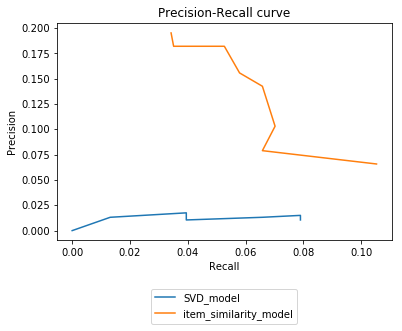

In [33]:
plot_precision_recall(svd_avg_precision_list, svd_avg_recall_list, "SVD_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

Conclusion: Item-similarity model works much better that SVD. 

Possible reasons:
1. Sparsity of the data.
2. Dataset not large enough.
3. Information from review texts is omitted. (This motivates us to try deep learning.)